In [1]:
accepted_categories = ["dress", "high_heel", "handbag", "skirt", "outerwear", "boot"]
label2id = {
    "dress": 0,
    "high_heel": 1, 
    "handbag": 2,
    "skirt": 3, 
    "outerwear": 4, 
    "boot": 5
    
}
id2label = {
    0: "dress",
    1: "high_heel", 
    2: "handbag",
    3: "skirt", 
    4: "outerwear", 
    5: "boot"
}

RANDOM_STATE = 12345

In [2]:
import os
import pandas as pd

CATEGORY_KEYWORDS = {
    "dresses": "dress",
    "skirts": "skirt",
    "boots": "boot",
    "coat": "outerwear",
    "coats": "outerwear",
    "outerwear": "outerwear",
    "bag": "handbag",
    "bags": "handbag",
    "high-heels": "high_heel",
    "high_heels": "high_heel",
    "heels": "high_heel",
}

def categorize_image(url: str) -> str:
    filename = os.path.basename(url).lower()
    for keyword, category in CATEGORY_KEYWORDS.items():
        if keyword in filename:
            return category
    return "other"

In [3]:
information_dataframe = pd.read_csv("../slowfashion/information.csv")
information_dataframe["global_category"] = information_dataframe["path"].apply(categorize_image)
information_dataframe["label_id"] = information_dataframe["global_category"].apply(lambda item: label2id[item] if item in label2id else -1)

In [4]:
information_dataframe.groupby("global_category").size()

global_category
boot           47
dress         212
handbag       135
high_heel     130
other        2142
outerwear     247
skirt          95
dtype: int64

In [5]:
information_dataframe=information_dataframe[information_dataframe["global_category"] != "other"].query("type == 'FRONT'")

In [6]:
information_dataframe.shape

(137, 4)

In [7]:
information_dataframe.groupby("global_category").size()

global_category
boot          8
dress        38
handbag      17
high_heel    18
outerwear    37
skirt        19
dtype: int64

In [8]:
#information_dataframe.query("label_id == -1")["path"].apply(lambda item: item.split("/")[-1]).unique()

In [9]:
#information_dataframe[information_dataframe["path"].str.lower().str.contains("dress")].groupby("global_category").size()

# Validation

In [10]:
import tensorflow as tf

IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def decode_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0  # Normalizar
    return image, label

def prepare_dataset(df, shuffle=True):
    paths = df["path"].values
    labels = df["label_id"].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=20_000)  # optimize memory
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    #ds = ds.repeat()
    ds = ds.apply(tf.data.experimental.ignore_errors())
    return ds

val_ds = prepare_dataset(information_dataframe, shuffle=True)

2025-05-18 22:03:02.533751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747598582.545153   37786 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747598582.548875   37786 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747598582.558272   37786 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747598582.558281   37786 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747598582.558282   37786 computation_placer.cc:177] computation placer alr

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


I0000 00:00:1747598584.339147   37786 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9536 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:0a:00.0, compute capability: 8.6


In [11]:
import tensorflow as tf

IMG_SIZE_2 = 248
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def decode_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE_2, IMG_SIZE_2])
    image = image / 255.0  # Normalizar
    return image, label

def prepare_dataset(df, shuffle=True):
    paths = df["path"].values
    labels = df["label_id"].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=20_000)  # optimize memory
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    #ds = ds.repeat()
    ds = ds.apply(tf.data.experimental.ignore_errors())
    return ds


val_248_ds = prepare_dataset(information_dataframe, shuffle=True)

In [12]:
from utils.performance import plot_top3_predictions, evaluate_and_save_metrics, plot_random_images_per_category

In [13]:
from tensorflow.keras.models import load_model

def load_trained_model(model_path):
    """
    Loads a Keras model from the specified file path.

    Parameters:
    - model_path (str): Path to the saved model file (e.g., .h5 or .keras)

    Returns:
    - model (tf.keras.Model): The loaded model
    """
    model = load_model(model_path)
    print(f"✅ Model loaded from: {model_path}")
    return model


In [14]:
mobile_tl_model = load_trained_model("models/model_mobilenet_tl/best_model.h5")
efficient_tl_model = load_trained_model("models/efficient_net_tl/best_model.h5")

mobile_from_zero_model = load_trained_model("models/from_zero_mobile_net//best_model.h5")
efficient_from_zero_model = load_trained_model("models/from_zero_efficient_net//best_model.h5")

✅ Model loaded from: models/model_mobilenet_tl/best_model.h5


✅ Model loaded from: models/efficient_net_tl/best_model.h5


✅ Model loaded from: models/from_zero_mobile_net//best_model.h5


✅ Model loaded from: models/from_zero_efficient_net//best_model.h5


In [15]:
evaluate_and_save_metrics(mobile_tl_model, val_ds, id2label, output_folder="results/mobile_net_tl/")

I0000 00:00:1747598589.273967   37863 service.cc:152] XLA service 0x7f2fb4001f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747598589.273996   37863 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2025-05-18 22:03:09.288851: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747598589.474332   37863 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-18 22:03:10.003022: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_661', 80 bytes spill stores, 120 bytes spill loads

2025-05-18 22:03:10.150675: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_66


✅ Accuracy:     0.7445
🎯 Top-2 Acc:    0.8978
🎯 Top-3 Acc:    0.9416

📊 Per-class metrics:

dress            Count: 38    Precision: 1.0000  Recall: 0.4737  F1: 0.6429
high_heel        Count: 18    Precision: 0.9231  Recall: 0.6667  F1: 0.7742
handbag          Count: 17    Precision: 0.6250  Recall: 0.8824  F1: 0.7317
skirt            Count: 19    Precision: 0.9000  Recall: 0.9474  F1: 0.9231
outerwear        Count: 37    Precision: 0.7111  Recall: 0.8649  F1: 0.7805
boot             Count: 8     Precision: 0.4118  Recall: 0.8750  F1: 0.5600

📁 Report saved to: results/mobile_net_tl/classification_report.xlsx


In [16]:
evaluate_and_save_metrics(efficient_tl_model, val_248_ds, id2label, output_folder="results/efficient_tl/")

2025-05-18 22:03:18.089926: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2279', 4 bytes spill stores, 4 bytes spill loads

2025-05-18 22:03:18.230233: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2279', 60 bytes spill stores, 60 bytes spill loads

2025-05-18 22:03:18.483658: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2279', 1180 bytes spill stores, 1244 bytes spill loads

2025-05-18 22:03:18.491824: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2279', 948 bytes spill stores, 948 bytes spill loads

2025-05-18 22:03:24.710151: I extern


✅ Accuracy:     0.2847
🎯 Top-2 Acc:    0.4234
🎯 Top-3 Acc:    0.6642

📊 Per-class metrics:

dress            Count: 38    Precision: 0.0000  Recall: 0.0000  F1: 0.0000
high_heel        Count: 18    Precision: 0.2667  Recall: 0.2222  F1: 0.2424
handbag          Count: 17    Precision: 0.0000  Recall: 0.0000  F1: 0.0000
skirt            Count: 19    Precision: 0.3500  Recall: 0.3684  F1: 0.3590
outerwear        Count: 37    Precision: 0.2800  Recall: 0.7568  F1: 0.4088
boot             Count: 8     Precision: 0.0000  Recall: 0.0000  F1: 0.0000

📁 Report saved to: results/efficient_tl/classification_report.xlsx


2025-05-18 22:03:27.804611: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
evaluate_and_save_metrics(mobile_from_zero_model, val_248_ds, id2label, output_folder="results/mobile_from_zero/")

2025-05-18 22:03:28.866832: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-18 22:03:29.012648: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-18 22:03:29.145311: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


2025-05-18 22:03:31.562000: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-18 22:03:31.687752: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-18 22:03:31.815104: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



✅ Accuracy:     0.1971
🎯 Top-2 Acc:    0.3869
🎯 Top-3 Acc:    0.6423

📊 Per-class metrics:

dress            Count: 38    Precision: 0.2667  Recall: 0.2105  F1: 0.2353
high_heel        Count: 18    Precision: 0.1579  Recall: 0.1667  F1: 0.1622
handbag          Count: 17    Precision: 0.5000  Recall: 0.0588  F1: 0.1053
skirt            Count: 19    Precision: 0.1429  Recall: 0.4211  F1: 0.2133
outerwear        Count: 37    Precision: 0.2593  Recall: 0.1892  F1: 0.2188
boot             Count: 8     Precision: 0.0000  Recall: 0.0000  F1: 0.0000

📁 Report saved to: results/mobile_from_zero/classification_report.xlsx


In [18]:
evaluate_and_save_metrics(efficient_from_zero_model, val_248_ds, id2label, output_folder="results/efficient_from_zero/")


✅ Accuracy:     0.1095
🎯 Top-2 Acc:    0.2482
🎯 Top-3 Acc:    0.3869

📊 Per-class metrics:

dress            Count: 38    Precision: 0.0000  Recall: 0.0000  F1: 0.0000
high_heel        Count: 18    Precision: 0.1429  Recall: 0.5000  F1: 0.2222
handbag          Count: 17    Precision: 0.0625  Recall: 0.2353  F1: 0.0988
skirt            Count: 19    Precision: 0.2000  Recall: 0.1053  F1: 0.1379
outerwear        Count: 37    Precision: 0.0000  Recall: 0.0000  F1: 0.0000
boot             Count: 8     Precision: 0.0000  Recall: 0.0000  F1: 0.0000

📁 Report saved to: results/efficient_from_zero/classification_report.xlsx


2025-05-18 22:03:39.831521: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Sample

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


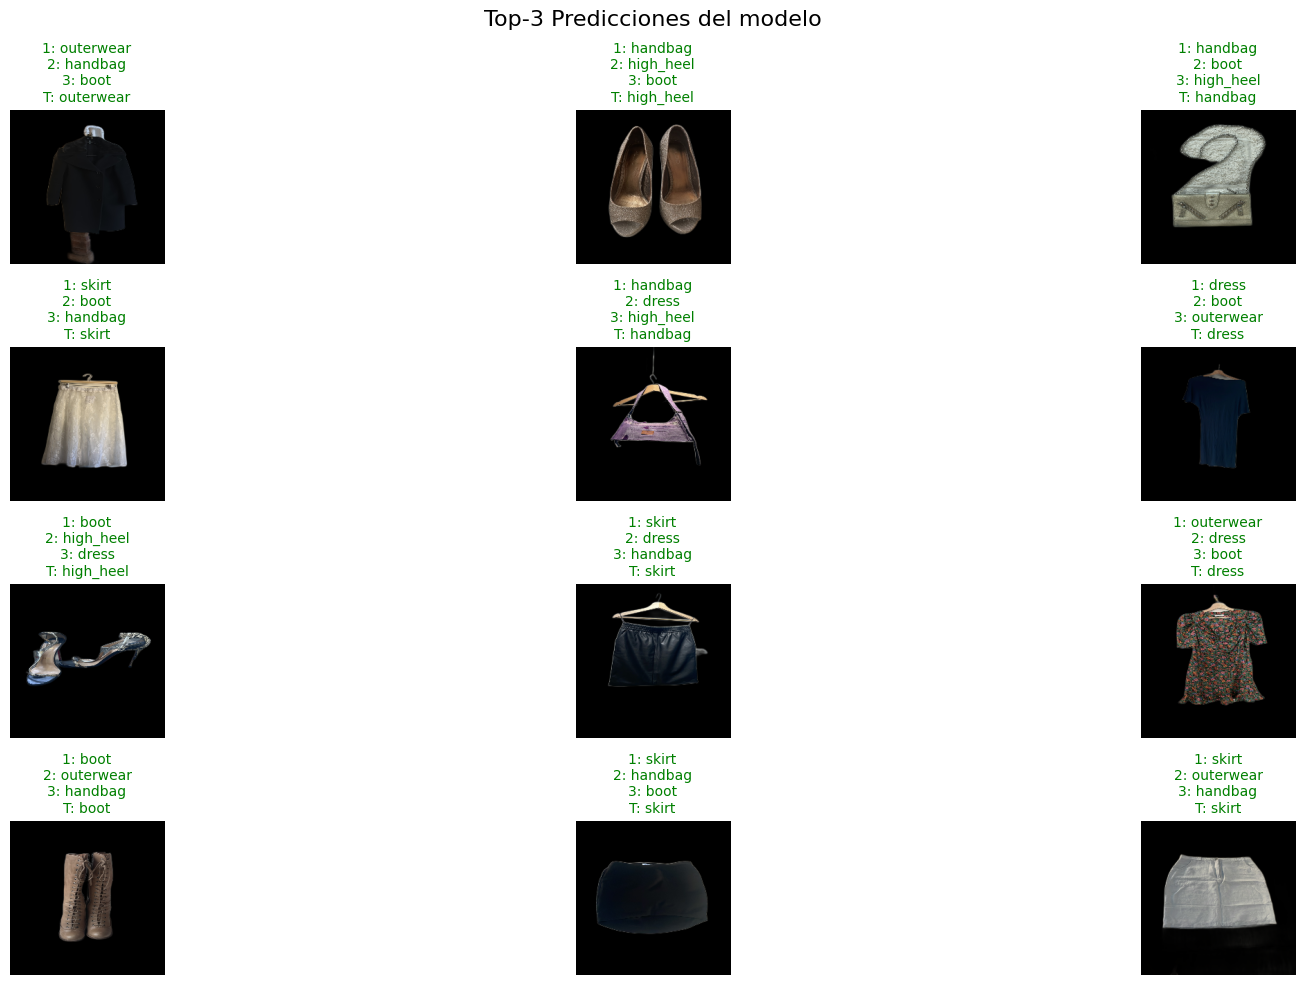

In [19]:
plot_top3_predictions(mobile_tl_model, val_ds, id2label, rows=4, cols=3)

In [22]:
from utils.performance import compare_models_metrics
model_list = [
    ("mobile_tl_model", mobile_tl_model,0),
    ("efficient_tl_model", efficient_tl_model,1),
    ("mobile_from_zero_model", mobile_from_zero_model,1),
    ("efficient_from_zero_model", efficient_from_zero_model,1),
]
df_summary, df_detailed = compare_models_metrics(model_list, [val_ds, val_248_ds], id2label, "results/summary/")


📁 Report saved to: results/summary/models_comparison_report.xlsx


In [23]:
df_summary

,model,accuracy,top_2_accuracy,top_3_accuracy
0,mobile_tl_model,0.744526,0.897810,0.941606
1,efficient_tl_model,0.291971,0.423358,0.664234
2,mobile_from_zero_model,0.197080,0.386861,0.642336
3,efficient_from_zero_model,0.124088,0.248175,0.379562


In [24]:
df_detailed

,model,class_id,class_name,count,precision,recall,f1_score
0,mobile_tl_model,0,dress,38,1.000000,0.473684,0.642857
1,mobile_tl_model,1,high_heel,18,0.923077,0.666667,0.774194
2,mobile_tl_model,2,handbag,17,0.625000,0.882353,0.731707
3,mobile_tl_model,3,skirt,19,0.900000,0.947368,0.923077
4,mobile_tl_model,4,outerwear,37,0.711111,0.864865,0.780488
5,mobile_tl_model,5,boot,8,0.411765,0.875000,0.560000
6,efficient_tl_model,0,dress,38,0.000000,0.000000,0.000000
7,efficient_tl_model,1,high_heel,18,0.312500,0.277778,0.294118
8,efficient_tl_model,2,handbag,17,0.000000,0.000000,0.000000
9,efficient_tl_model,3,skirt,19,0.350000,0.368421,0.358974
